In [2]:
!pip install opensmile gdown transformers soundfile shap --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.0/996.0 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 30.3 MB/s eta 0:00:00


In [10]:
import os
import tarfile
from pathlib import Path
import os
import tempfile
import concurrent.futures
from pathlib import Path
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio, display
import pandas as pd
import numpy as np
import soundfile as sf
from transformers import pipeline
import torch

from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import shap
from sklearn.ensemble import RandomForestClassifier

### Accessing Dataset

In [ ]:
# install dataset using gdown
!gdown 1p4ZQOwbHkD2RAvq2K5ekY5gcMi24XLnS

tarball_filename = "ADReSSo21-diagnosis-train.tar"

# extract contents from tarball
with tarfile.open(tarball_filename, 'r:*') as tar:
    tar.extractall(path="./")

# remove tarball after extraction
os.remove(tarball_filename)

Downloading...
From (original): https://drive.google.com/uc?id=1p4ZQOwbHkD2RAvq2K5ekY5gcMi24XLnS
From (redirected): https://drive.google.com/uc?id=1p4ZQOwbHkD2RAvq2K5ekY5gcMi24XLnS&confirm=t&uuid=b3ddf379-a455-4aa3-a747-bf6402e534b9
To: /content/ADReSSo21-diagnosis-train.tar
100% 1.75G/1.75G [00:18<00:00, 92.3MB/s]


In [ ]:
def get_dataset_paths(dataset_root: str = "ADReSSo21/diagnosis/train"):
    """
    Return a dictionary containing paths for the audio and segmentation directories.
    """
    dataset_dir = Path(dataset_root)
    return {
        "audio": dataset_dir / "audio",
        "audio_ad": dataset_dir / "audio" / "ad",
        "audio_cn": dataset_dir / "audio" / "cn",
        "segmentation": dataset_dir / "segmentation",
        "segmentation_ad": dataset_dir / "segmentation" / "ad",
        "segmentation_cn": dataset_dir / "segmentation" / "cn",
    }

def load_audio_file(file_path: Path):
    """Load the audio waveform and its sampling rate using soundfile."""
    return sf.read(file_path)

def load_segmentation(seg_file: Path):
    """Load the segmentation CSV into a Pandas DataFrame."""
    return pd.read_csv(seg_file)

def extract_patient_segments(audio: np.ndarray, sr: int, seg_df: pd.DataFrame, speaker: str = "PAR"):
    """
    Extract patient segments from the audio as specified by the segmentation CSV.

    Returns:
      - patient_mask: Array with patient segments (NaN elsewhere).
      - concatenated: All patient segments concatenated into a single array.
      - segments: List of (begin_sample, end_sample) tuples.
    """
    patient_df = seg_df[seg_df["speaker"] == speaker]
    patient_mask = np.full_like(audio, np.nan)
    segments_list = []
    segments = []
    for _, row in patient_df.iterrows():
        begin_sample = int(float(row["begin"]) * sr / 1000)
        end_sample = int(float(row["end"]) * sr / 1000)
        patient_mask[begin_sample:end_sample] = audio[begin_sample:end_sample]
        segments_list.append(audio[begin_sample:end_sample])
        segments.append((begin_sample, end_sample))
    concatenated = np.concatenate(segments_list) if segments_list else np.array([])
    return patient_mask, concatenated, segments

def process_audio(audio_file: Path, seg_file: Path, plot: bool = False):
    """
    Load an audio file and its corresponding segmentation CSV,
    extract the patient-only segments, and optionally plot the waveform.

    Returns:
      audio, sr, patient_mask, concatenated (patient-only audio), segments.
    """
    audio, sr = load_audio_file(audio_file)
    seg_df = load_segmentation(seg_file)
    patient_mask, concatenated, segments = extract_patient_segments(audio, sr, seg_df)
    if plot:
        time_axis = np.linspace(0, len(audio) / sr, num=len(audio))
        plt.figure(figsize=(14, 4))
        plt.plot(time_axis, audio, label="Original")
        plt.plot(time_axis, patient_mask, label="Patient-Only")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title("Patient Speech Isolation")
        plt.legend()
        plt.show()
    return audio, sr, patient_mask, concatenated, segments

def init_transcriber(model_name: str = "openai/whisper-large", device: int = 0):
    """
    Initialize the Hugging Face ASR pipeline using GPU.

    Set device=0 to use your GPU.
    """
    return pipeline("automatic-speech-recognition", model=model_name, device=device)

def transcribe_audio_file(file_path: str, transcriber) -> str:
    """
    Transcribe an audio file given its file path using the provided transcriber.

    Returns the transcription text.
    """
    result = transcriber(file_path, return_timestamps=True)
    return result.get("text", "")

def create_transcription_df(transcription_records: list) -> pd.DataFrame:
    """
    Create a Pandas DataFrame from a list of transcription records.
    """
    return pd.DataFrame(transcription_records)

# -------------------------------------------------------------------------------
# Main Function: Get Transcripts for a Specific Group (Process All Files)
# -------------------------------------------------------------------------------
def get_transcripts_for_group(group: str):
    """
    Process all audio files from a specified group ("ad" or "cn") on GPU,
    print the word count for each transcript, and save the sorted transcripts
    to a CSV file.

    The CSV file is named differently based on the group.
    """
    paths = get_dataset_paths()
    device = 0  # Use GPU (device index 0)
    model_name = "openai/whisper-large"

    if group.lower() == "ad":
        audio_files = sorted(list(paths["audio_ad"].glob("*.wav")), key=lambda f: f.name)
        seg_dir = paths["segmentation_ad"]
        csv_filename = "sorted_patient_transcriptions_ad.csv"
    elif group.lower() == "cn":
        audio_files = sorted(list(paths["audio_cn"].glob("*.wav")), key=lambda f: f.name)
        seg_dir = paths["segmentation_cn"]
        csv_filename = "sorted_patient_transcriptions_cn.csv"
    else:
        raise ValueError("Unknown group. Please specify 'ad' or 'cn'.")

    print(f"Processing {len(audio_files)} audio files from the '{group.upper()}' group on GPU.")
    transcripts = []
    transcriber = init_transcriber(model_name=model_name, device=device)  # Initialize once for efficiency

    for audio_file in audio_files:
        seg_file = seg_dir / f"{audio_file.stem}.csv"

        # Process audio to extract the patient-only audio
        audio, sr, patient_mask, concatenated, segments = process_audio(audio_file, seg_file, plot=False)
        if concatenated.size == 0:
            transcript = "No patient speech segments found."
        else:
            # Write the concatenated patient-only audio to a temporary WAV file
            with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp_file:
                temp_filename = tmp_file.name
            sf.write(temp_filename, concatenated, sr)
            transcript = transcribe_audio_file(temp_filename, transcriber)
            os.remove(temp_filename)

        transcripts.append({"file_name": audio_file.name, "transcription": transcript})
        word_count = len(transcript.split())
        print(f"File '{audio_file.name}': {word_count} words in transcript.")

    # Sort the transcripts by file name and save to CSV
    transcripts = sorted(transcripts, key=lambda x: x["file_name"])
    df = create_transcription_df(transcripts)
    df.to_csv(csv_filename, index=False)
    print(f"All sorted transcriptions for the '{group.upper()}' group saved to {csv_filename}")


### Transcription


In [ ]:
# Process all audio files from the AD group and save to CSV
get_transcripts_for_group("ad")
# Process all audio files from the CN group and save to CSV
get_transcripts_for_group("cn")

Processing 87 audio files from the 'AD' group on GPU.


Device set to use cuda:0


File 'adrso024.wav': 182 words in transcript.
File 'adrso025.wav': 195 words in transcript.
File 'adrso027.wav': 83 words in transcript.
File 'adrso028.wav': 47 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso031.wav': 90 words in transcript.
File 'adrso032.wav': 184 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso033.wav': 72 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso035.wav': 84 words in transcript.
File 'adrso036.wav': 40 words in transcript.
File 'adrso039.wav': 28 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso043.wav': 250 words in transcript.
File 'adrso045.wav': 291 words in transcript.
File 'adrso046.wav': 108 words in transcript.
File 'adrso047.wav': 94 words in transcript.
File 'adrso049.wav': 151 words in transcript.
File 'adrso053.wav': 201 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso054.wav': 93 words in transcript.
File 'adrso055.wav': 121 words in transcript.
File 'adrso056.wav': 289 words in transcript.
File 'adrso059.wav': 63 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso060.wav': 46 words in transcript.
File 'adrso063.wav': 27 words in transcript.
File 'adrso068.wav': 62 words in transcript.
File 'adrso070.wav': 262 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso071.wav': 87 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso072.wav': 91 words in transcript.
File 'adrso074.wav': 103 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso075.wav': 60 words in transcript.
File 'adrso077.wav': 63 words in transcript.
File 'adrso078.wav': 87 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso089.wav': 111 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso090.wav': 44 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso092.wav': 75 words in transcript.
File 'adrso093.wav': 146 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso098.wav': 111 words in transcript.
File 'adrso106.wav': 121 words in transcript.
File 'adrso109.wav': 106 words in transcript.
File 'adrso110.wav': 101 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso112.wav': 76 words in transcript.
File 'adrso116.wav': 52 words in transcript.
File 'adrso122.wav': 30 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso123.wav': 49 words in transcript.
File 'adrso125.wav': 86 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso126.wav': 64 words in transcript.
File 'adrso128.wav': 25 words in transcript.
File 'adrso130.wav': 33 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso134.wav': 31 words in transcript.
File 'adrso138.wav': 78 words in transcript.
File 'adrso141.wav': 49 words in transcript.
File 'adrso142.wav': 50 words in transcript.
File 'adrso144.wav': 78 words in transcript.
File 'adrso187.wav': 109 words in transcript.
File 'adrso188.wav': 52 words in transcript.
File 'adrso189.wav': 98 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso190.wav': 194 words in transcript.
File 'adrso192.wav': 84 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso197.wav': 91 words in transcript.
File 'adrso198.wav': 41 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso200.wav': 170 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso202.wav': 107 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso205.wav': 105 words in transcript.
File 'adrso206.wav': 95 words in transcript.
File 'adrso209.wav': 71 words in transcript.
File 'adrso211.wav': 147 words in transcript.
File 'adrso212.wav': 100 words in transcript.
File 'adrso215.wav': 53 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso216.wav': 80 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso218.wav': 49 words in transcript.
File 'adrso220.wav': 90 words in transcript.
File 'adrso222.wav': 103 words in transcript.
File 'adrso223.wav': 72 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso224.wav': 132 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso228.wav': 79 words in transcript.
File 'adrso229.wav': 140 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso232.wav': 98 words in transcript.
File 'adrso233.wav': 133 words in transcript.
File 'adrso234.wav': 100 words in transcript.
File 'adrso236.wav': 39 words in transcript.
File 'adrso237.wav': 72 words in transcript.
File 'adrso244.wav': 85 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso245.wav': 56 words in transcript.
File 'adrso246.wav': 67 words in transcript.
File 'adrso247.wav': 94 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso248.wav': 72 words in transcript.
File 'adrso249.wav': 57 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso250.wav': 148 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso253.wav': 99 words in transcript.
All sorted transcriptions for the 'AD' group saved to sorted_patient_transcriptions_ad.csv
Processing 79 audio files from the 'CN' group on GPU.


Device set to use cuda:0


File 'adrso002.wav': 171 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso003.wav': 82 words in transcript.
File 'adrso005.wav': 141 words in transcript.
File 'adrso007.wav': 63 words in transcript.
File 'adrso008.wav': 137 words in transcript.
File 'adrso010.wav': 41 words in transcript.
File 'adrso012.wav': 137 words in transcript.
File 'adrso014.wav': 138 words in transcript.
File 'adrso015.wav': 99 words in transcript.
File 'adrso016.wav': 79 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso017.wav': 117 words in transcript.
File 'adrso018.wav': 5 words in transcript.
File 'adrso019.wav': 5 words in transcript.
File 'adrso021.wav': 5 words in transcript.
File 'adrso022.wav': 5 words in transcript.
File 'adrso023.wav': 5 words in transcript.
File 'adrso148.wav': 240 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso151.wav': 49 words in transcript.
File 'adrso152.wav': 130 words in transcript.
File 'adrso153.wav': 110 words in transcript.
File 'adrso154.wav': 60 words in transcript.
File 'adrso156.wav': 95 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso157.wav': 128 words in transcript.
File 'adrso158.wav': 100 words in transcript.
File 'adrso159.wav': 57 words in transcript.
File 'adrso160.wav': 45 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso161.wav': 74 words in transcript.
File 'adrso162.wav': 135 words in transcript.
File 'adrso164.wav': 173 words in transcript.
File 'adrso165.wav': 82 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso167.wav': 151 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso168.wav': 129 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso169.wav': 63 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso170.wav': 87 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso172.wav': 133 words in transcript.
File 'adrso173.wav': 104 words in transcript.
File 'adrso177.wav': 108 words in transcript.
File 'adrso178.wav': 64 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso180.wav': 102 words in transcript.
File 'adrso182.wav': 90 words in transcript.
File 'adrso183.wav': 192 words in transcript.
File 'adrso186.wav': 79 words in transcript.
File 'adrso257.wav': 92 words in transcript.
File 'adrso259.wav': 183 words in transcript.
File 'adrso260.wav': 84 words in transcript.
File 'adrso261.wav': 114 words in transcript.
File 'adrso262.wav': 67 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso263.wav': 98 words in transcript.
File 'adrso264.wav': 89 words in transcript.
File 'adrso265.wav': 237 words in transcript.
File 'adrso266.wav': 72 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso267.wav': 117 words in transcript.
File 'adrso268.wav': 156 words in transcript.
File 'adrso270.wav': 109 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso273.wav': 101 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso274.wav': 286 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso276.wav': 493 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso277.wav': 140 words in transcript.
File 'adrso278.wav': 44 words in transcript.
File 'adrso280.wav': 229 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso281.wav': 123 words in transcript.
File 'adrso283.wav': 137 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso285.wav': 32 words in transcript.
File 'adrso286.wav': 103 words in transcript.
File 'adrso289.wav': 74 words in transcript.
File 'adrso291.wav': 186 words in transcript.
File 'adrso292.wav': 59 words in transcript.
File 'adrso296.wav': 139 words in transcript.
File 'adrso298.wav': 92 words in transcript.
File 'adrso299.wav': 107 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso300.wav': 54 words in transcript.
File 'adrso302.wav': 236 words in transcript.
File 'adrso307.wav': 170 words in transcript.
File 'adrso308.wav': 152 words in transcript.
File 'adrso309.wav': 104 words in transcript.
File 'adrso310.wav': 81 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso312.wav': 112 words in transcript.
File 'adrso315.wav': 101 words in transcript.


Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


File 'adrso316.wav': 88 words in transcript.
All sorted transcriptions for the 'CN' group saved to sorted_patient_transcriptions_cn.csv


### Feature Extraction

In [ ]:
# load data
df_ad = pd.read_csv("sorted_patient_transcriptions_ad.csv")
df_cn = pd.read_csv("sorted_patient_transcriptions_cn.csv")

# select first transcripts
transcript_ad = df_ad.loc[0, "transcription"]
transcript_cn = df_cn.loc[0, "transcription"]
print("AD:", transcript_ad)
print("CN:", transcript_cn)

# init model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model     = DistilBertModel.from_pretrained("distilbert-base-uncased")

# embed AD
inputs_ad = tokenizer(transcript_ad, return_tensors="pt", truncation=True, padding=True)
fv_ad     = model(**inputs_ad).last_hidden_state
print(fv_ad.shape)

# embed CN
inputs_cn = tokenizer(transcript_cn, return_tensors="pt", truncation=True, padding=True)
fv_cn     = model(**inputs_cn).last_hidden_state
print(fv_cn.shape)

AD transcript:  Here's a cookie jar and the lid is off the cookie jar. The boy is about to come down on the floor. And the girl, I don't know much about girls, but anyway, The housewife is in the kitchen and the sink is overflowing. The girl may be saying, say, ha ha ha, I told you so, or something like that. And I guess this must be the wife, although it might not be because maybe that was an apron and maybe this was the... There is... This should be a window there. The upper one is there. pathway. We don't know where the pathway is going to because we can't see it. Looks like there's flowers in the bushes or something like that. And here are some draperies. Well this one on this side is I don't see it the other side but I suspect it would be the same thing there. And the I guess I said the water was coming down on the floor. I don't know they here are two cups cups for coffee or something like that.
CN transcript:  Okay, I see a mom doing the dishes and the water's overflowing from t

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

AD transcript full sequence feature vector shape: torch.Size([1, 229, 768])
CN transcript full sequence feature vector shape: torch.Size([1, 221, 768])


### Training

In [1]:
# load transcripts & labels
df_ad = pd.read_csv("sorted_patient_transcriptions_ad.csv")
df_cn = pd.read_csv("sorted_patient_transcriptions_cn.csv")
texts = df_ad["transcription"].tolist() + df_cn["transcription"].tolist()
y     = np.array([1]*len(df_ad) + [0]*len(df_cn))

# init model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model     = DistilBertModel.from_pretrained("distilbert-base-uncased").eval()
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# extract features
features = []
with torch.no_grad():
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
        emb    = model(**inputs).last_hidden_state.squeeze(0).mean(dim=0)
        features.append(emb.cpu().numpy())
X = np.vstack(features)

# split & save
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)
for name, arr in [("X_train", X_train), ("X_test", X_test),
                  ("y_train", y_train), ("y_test", y_test)]:
    np.save(f"{name}.npy", arr)

# train & evaluate
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Acc:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Saved X_train.npy, X_test.npy, y_train.npy, y_test.npy
Test Accuracy: 0.824

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80        16
           1       0.80      0.89      0.84        18

    accuracy                           0.82        34
   macro avg       0.83      0.82      0.82        34
weighted avg       0.83      0.82      0.82        34



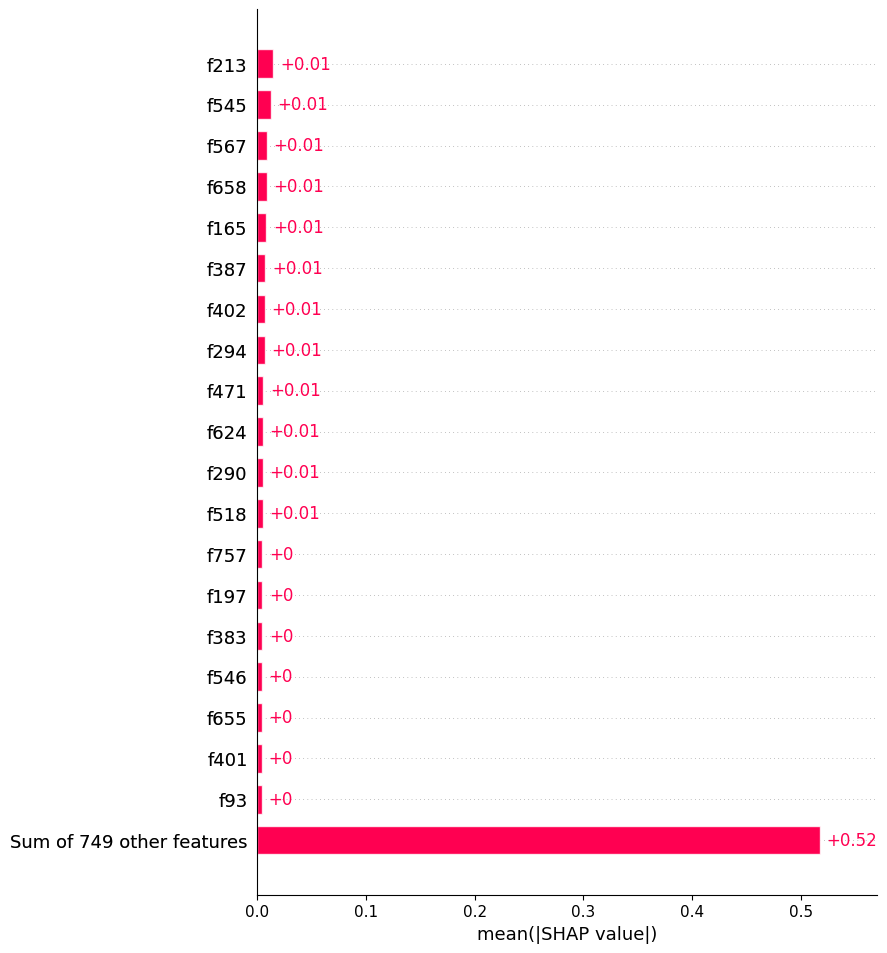

In [8]:
# load data
X_train = np.load("X_train.npy")
X_test  = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test  = np.load("y_test.npy")

# train model
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# compute SHAP values for class 1
explainer = shap.Explainer(clf, X_train, feature_names=[f"f{i}" for i in range(X_train.shape[1])])
shap_vals = explainer(X_test)[..., 1]

# plot top 20 features
shap.plots.bar(shap_vals, max_display=20)
plt.show()